# 第14回 生成AI入門

___
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tsuboshun/begin-python/blob/gh-pages/workbook/lecture14.ipynb)

___

## この授業で学ぶこと

今回は、データサイエンスの中でも最新の話題である生成AIについて学ぶ。

**生成AI**とは、テキスト、画像、動画、音声など、さまざまなデータから学習し、そこから新しいデータを生み出すことができる人工知能（AI）のことである。

例えば次のようなことが可能になっている：
- 文章を入力して、それを添削したり翻訳したりする
- 説明文を入力して、それに忠実な画像や動画を出力する
- 会議の音声データを入力して、議事録を出力する
- 数学の問題を入力して、長考の後、答えと解説を出力する

最近話題のChatGPTは、まるで人間と対話しているかのように自然な文章を生成できることで世界中から注目されている。

生成AIは現在も進化中で、新しいサービスが次々と登場しているが、基本的な仕組みはしばらく大きく変わらないと考えられる。生成AIを有効に活用したり将来の動向を予測したりするためには、その仕組みを理解することが非常に重要となる。

今回の授業では、生成AIの基本的な仕組みを理解し、さらにPythonプログラムを通して生成AIを利用できるようになることを目指す。わかりやすさを重視して、「文章を入力して文章を生成するタイプの生成AI（言語モデル）」を中心に取り扱う。また、生成AIサービスとしてはChatGPT（OpenAI）を主に用いるが、GoogleのGeminiやAnthropicのClaudeなど他の生成AIも同様の仕組みで動いている。

## 生成モデル

生成AIは、**生成モデル**という技術が元になっている。
生成モデルとは、既存のデータの特徴やパターンを学習し、それをもとに新しいデータを確率的に作り出す関数である。

### 条件付き確率

例えば、あるお店でのアイスクリームの売り上げを考えてみよう。
アイスクリームの売り上げは、その日の気温によって変化する。
このように、ある条件に応じて変わる確率を**条件付き確率**という。

条件付き確率は、次のように書かれる：

$p(売上個数 | 気温)$

これは「気温」と「売上個数」のところに数値を入れると、確率を表す数値が返ってくるような関数となっている。

例えば、このお店でアイスクリームを3個だけ仕入れた場合、気温が27度のときは次のようになる。
- $p(売上個数 = 0| 気温 = 27) \rightarrow 0.1$
- $p(売上個数 = 1| 気温 = 27) \rightarrow 0.2$
- $p(売上個数 = 2| 気温 = 27) \rightarrow 0.6$
- $p(売上個数 = 3| 気温 = 27) \rightarrow 0.1$

これらは確率なので、すべてを足すと1になることに注目しよう。

また、気温が10度のときは以下のようになる。
- $p(売上個数 = 0| 気温 = 10) \rightarrow 0.8$
- $p(売上個数 = 1| 気温 = 10) \rightarrow 0.2$
- $p(売上個数 = 2| 気温 = 10) \rightarrow 0$
- $p(売上個数 = 3| 気温 = 10) \rightarrow 0$

このように、条件が変われば確率の値も変わる。

### 生成モデルと条件付き確率

生成モデルも、これと同じように条件付き確率で表現できる。

$p( y | x; \theta )$
- $x$: 入力データ（例えば、文章や画像の説明文）
- $y$: 出力データ（例えば、生成される文章や画像） 
- $\theta$: パラメータ（モデルの性質を決める要素）

生成モデルは、この条件付き確率を使い、入力データに合った出力データを生成している。

ここで $\theta$ は**パラメータ**と呼ばれ、生成モデルがどのようなデータを生成するかを調整する役割を持つ。
先ほどのアイスクリームの例で言えば、パラメータとは「アイスクリームの値段」のようなものだ。
お店側が値段を変えることで、売れる個数を調整できるように、生成モデルもパラメータを変えることで出力結果を調整することができる。

生成モデルが適切な出力を行うためには、このパラメータ $\theta$ をデータから決定する必要がある。このパラメータを決定するプロセスを**学習**と呼ぶ。
あとで詳しく見るように、データをもとに勾配法という手法を使うことで学習を行う。

```{admonition} 単回帰モデル
パラメータについて具体的なイメージを持ってもらうため、簡単なモデルとして**単回帰モデル**を紹介する[^f1]。
単回帰モデルは以下のように2つのパラメータ $a$、$b$ を持つ関数として表される。

$y = ax + b + \varepsilon$
- $x$: 入力
- $y$: 出力
- $a, b$: パラメータ
- $\varepsilon$: ノイズ

単回帰モデルにおける $x$ と $y$ の関係は、パラメータ $a$、$b$ に依存して変わる。
生成モデルとパラメータの関係もこれと同じようなものと想像すればよい。
```

[^f1]: 単回帰モデルは、「新しいデータを作り出す」ためというより「既存データの関係性を説明する」ために用いられる。したがって、普通は生成モデルとは言わない。ここではパラメータつきのモデルを説明する目的で紹介している。

### 言語モデル

それでは、生成モデルの一つである言語モデルについて、詳しく見てみよう。
言語モデルの中でも膨大な数のパラメータを持ち、膨大なデータを使って学習されるものを**大規模言語モデル**（**Large Language Model, LLM**） という。
例えば、ChatGPTの内部では**GPT**（**Generative Pre-trained Transformer**）という大規模言語モデルが使われている。
ChatGPTの最新版の詳しい仕組みは非公開だが、GPT-3などの過去のモデルの情報を参考に、その動作原理を理解することができる。

言語モデルは文章全体を一度に生成するのではなく、**トークン**と呼ばれる単位で順番に生成する。日本語では主に「文字」、英語では主に「単語」をトークンとする。生成されたトークンを改めて入力として、次のトークンを生成するということを繰り返すため、言語モデルは**自己回帰モデル**とも呼ばれる。

例えば、言語モデルに「以下を英訳して：私の名前は春子です。」という文章を入力した場合を考えてみよう。ChatGPTなどでこの文章を入力すると、例えば「My name is Haruko.」と返ってくる。このとき内部では以下のような手順で文章が生成される。

```{figure} ./pic/language-model.png
---
width: 700px
name: language-model
---
言語モデルの生成過程
```

まず、言語モデルは文章をトークンに分割して処理する。
トークンはモデルが理解できるように数値で表現される。GPT-3の場合、使用されるトークンの数は全部で50257個あり、それぞれのトークンは50257次元のベクトル（数値の並び）として表される。
このベクトル表現を具体的には**one-hotベクトル**という。これは、各トークンを、1つの要素だけ1で、それ以外の要素がすべて0のベクトルで表現する方法である。例えば、あるトークンがインデックスの3に対応している場合、そのトークンは $[0, 0, 0, 1, 0, ..., 0]$ という形で表される。

このようなトークンのベクトル列を言語モデルに入力すると、同じ50257次元のベクトルが出力される。この出力は「次に来る可能性のあるトークンの確率分布」を表している。モデルは、この確率分布に基づいて次のトークンを選択する。例えば、出力されたベクトルの中で「I」や「My」に対応する要素が大きければ、それらが選ばれる可能性が高くなる。ただし、最大値を取るトークンが常に選ばれるわけではなく、確率的に選ばれることに注意しよう。

次に言語モデルに「以下を英訳して：私の名前は春子です。My」が入力され、同様に50257次元のベクトルが出力される。
今回は「name」に対応する値が大きくなっており、それを反映して「name」と出力されている。このプロセスを繰り返すことで文章を生成することができる。

ここまでの説明から示唆されるように、言語モデルは「数値の配列を入力として受け取り、数値の配列を出力する、パラメータで調整された関数」になっている。
この関数として、最近の言語モデルでは主に**Transformer**というモデルが使われている[^f2]。Transformerのパラメータ数は非常に多く、例えばGPT-3ではその数が約1750億個にもなる。

これらのパラメータの値が、言語モデルの性能を決定する。
例えば、パラメータがランダムに設定されると、意味のないトークンがランダムに生成されてしまう。そのため、言語モデルを役に立つツールとして使うためには、適切なパラメータを設定（学習）することが非常に重要になるのである。

[^f2]: Transformerの詳細が気になる方には、こちらの解説動画をお勧めする：[解説動画1](https://youtu.be/wjZofJX0v4M?si=A266N3VMzHLVkcd3)、[解説動画2](https://youtu.be/eMlx5fFNoYc?si=Y9j7yx0pGnrnXXqr)

## 学習のしくみ

データをもとにモデルのパラメータを調整し、モデルの出力を望ましいものに近づける過程を**学習**という。言語モデルを含む近年のほとんどの**深層学習モデル**（膨大な数のパラメータを持つモデル）の学習には、**勾配法**という手法が用いられている。以下では、勾配法の基本的な考え方を単回帰モデルを用いて説明し、その後で言語モデルへの応用を解説する。

### 勾配法

第11回でも扱った関係式 $y = 2x + \varepsilon$ を満たす2次元データ $(x, y)$ が100個あるとする。
ここで $\varepsilon$ は平均 $0$、標準偏差 $1$ の正規分布に従うノイズである。
このデータについて、（生成式を知らなかったとして）$x$ と $y$ の関係を予測するために、以下のような単回帰モデルを考える。

$y = ax + b$

モデルのパラメータ $a$ と $b$ を求める際に勾配法を利用することを考える[^f3]。最初に $a$ と $b$ はランダムな値で設定される。初期状態におけるデータと予測モデルの関係は下図の左側に示されている。

[^f3]: もちろん私たちは生成式を知っているので、およそ $a = 2$、$b = 0$ が正解と予想できるが、ここでは生成式を知らなかったという体で話をしている。また単回帰モデルは簡単なモデルなので、$a$ と $b$ の解析解（データから直接求める計算式）が存在するが、ここでは説明のためにあえて勾配法を使う。

In [ ]:
pip install japanize_matplotlib

In [1]:
import random
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

from ipywidgets import Button, VBox, Layout, Output
from IPython.display import display
plt.rcParams.update({'font.size': 14})  # 文字サイズを14pxとする

# 0から10までの0.1刻みの配列
x = np.arange(0, 10, 0.1)

# y = 2x + eps　（epsはノイズ）
eps = np.random.normal(loc=0, scale=1, size=len(x))
y = x * 2 + eps


class LinearModel:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def predict(self, x):
        return self.a * x + self.b

    def perturb(self, da, db):
        return LinearModel(self.a + da, self.b + db)

def loss(x, y, model):
    return np.sum((y - model.predict(x)) ** 2) / len(x)

In [2]:
plot_output = Output()
model = LinearModel(2*random.random()-1, 2*random.random()-1)
a_list = [model.a]
b_list = [model.b]


def update_param(event=None):
    """勾配法によりモデルのパラメータを更新する
    """
    global model, a_list, b_list
    with plot_output:
        d = 10 ** (-4)  # 勾配を計算するための微小変化
        alpha = 10 ** (-2)  # 学習率 （勾配の方向にパラメータをどれくらい動かすか）
        
        grad_a = (loss(x, y, model.perturb(d, 0)) - loss(x, y, model)) / d
        grad_b = (loss(x, y, model.perturb(0, d)) - loss(x, y, model)) / d
        model = model.perturb(-grad_a * alpha, -grad_b * alpha)
        a_list.append(model.a)
        b_list.append(model.b)


def plot_graph():
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
    axes[0].scatter(x, y, color="royalblue")
    y_pred = model.predict(x)
    axes[0].plot(x, y_pred, color="forestgreen")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].set_title("データとモデルの予測")

    a_range = np.linspace(-1, 5, 100)
    b_range = np.linspace(-6, 6, 100)
    A, B = np.meshgrid(a_range, b_range)
    Z = np.array([[loss(x, y, LinearModel(a, b)) for a in a_range] for b in b_range])
    cp = axes[1].contour(A, B, Z, levels=10)

    axes[1].quiver(a_list[:-1], b_list[:-1], 
       [a_list[i+1] - a_list[i] for i in range(len(a_list)-1)], 
       [b_list[i+1] - b_list[i] for i in range(len(b_list)-1)], 
       angles="xy", scale_units="xy", scale=1, color="k")
    axes[1].scatter(model.a, model.b, s=50, c="k")
    axes[1].set_xlabel("a")
    axes[1].set_ylabel("b")
    axes[1].set_title("パラメータと誤差関数")
    plt.colorbar(cp)
    plt.show()
    

def plot_graph_output(event=None):
    with plot_output:
        plot_output.clear_output(wait=True)
        plot_graph()


# ボタンを作成
button_grad = Button(
    description="勾配法",
    layout=Layout(width='150px', height='40px')
)
button_grad.on_click(update_param)

button_plot = Button(
    description="プロット",
    layout=Layout(width='150px', height='40px')
)
button_plot.on_click(plot_graph_output)

layout = VBox([button_grad, button_plot, plot_output])
plot_graph_output()
display(layout)

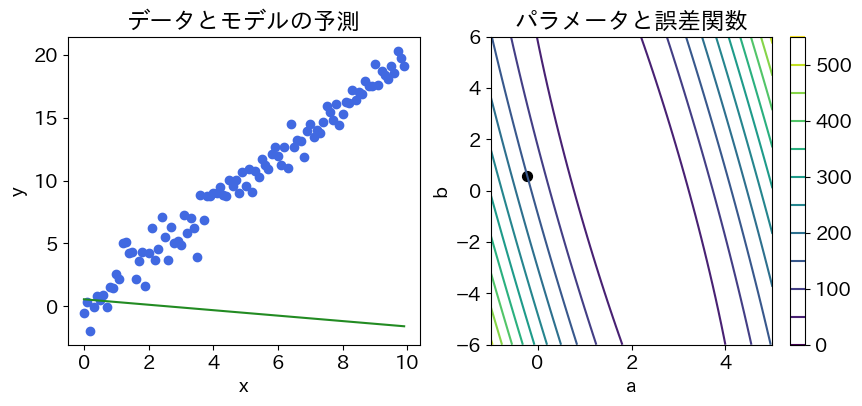

In [3]:
plot_graph()

学習の目的は、モデル $y = ax + b$ がデータによく当てはまるようにパラメータ $a$ と $b$ を設定することである。そのためには、モデルの予測がデータとどの程度ずれているかを測る**誤差関数**を定義する必要がある。ここでは一般的に利用される**平均二乗誤差**（**Mean Squared Error, MSE**）を採用する。MSEは次の式で定義される（$N = 100$）。

${\rm{MSE}}(a, b) = \frac{1}{N}\sum_i^N (y_i - (ax_i + b))^2$

これは「各データの実測値 $y_i$ とモデルの予測値 $ax_i + b$ の差を二乗した値」を、すべてのデータについて平均したものを表している。モデルの予測が完全にデータと一致すれば、MSEの値は0になる。

上図の右側には、パラメータ $a$ と $b$ の値ごとの誤差関数の値を示した等高線図を示している。等高線図は、誤差関数の値が等しい点を結んだもので、地図の標高を示す等高線と同じように考えられる。

勾配法の基本的な考え方は「パラメータを誤差関数の値が小さくなる方向へ少しずつ更新していくこと」である。このとき、誤差関数の増加速度が最も大きくなる方向を**勾配**と呼ぶ。勾配法はこの勾配の逆方向（誤差関数が減少する方向）にパラメータを更新していく方法である。

具体的には、${\rm{d}}a$、${\rm{d}}b$ を十分小さい値として、それぞれのパラメータを以下のように更新する。

- $a$ の更新  

<big>$a \leftarrow a - \alpha\frac{{\rm{MSE}}(a + {\rm{d}}a, ~b) - {\rm{MSE}}(a, ~b)}{{\rm{d}}a}$</big>

- $b$ の更新  

<big>$b \leftarrow b - \alpha\frac{{\rm{MSE}}(a, ~b + {\rm{d}}b) - {\rm{MSE}}(a, ~b)}{{\rm{d}}b}$</big>

これらの式の分数部分が「誤差関数の傾き（勾配）」を表している。この勾配は関数の「最も急に上昇する方向」を示すため、勾配法ではその逆向き、つまり「最も急に下降する方向」へパラメータを更新することで、効率的に誤差を小さくすることができる。
$\alpha$ はパラメータの更新幅を決める定数で、**学習率**と呼ばれる。

微積分になじみのない人にとっては少し難しいかもしれないが、勾配とは「坂道の傾き」のようなものであり、「下り坂を少しずつ降りていくイメージ」を持つと理解しやすい。上記の更新を繰り返すことで、徐々にモデルのパラメータが改善され、予測精度が向上していくことになる。

Google Colabのノートブックでは、この単回帰モデルの勾配法による学習を実際に試すことができる。「勾配法」と「プロット」を交互にクリックすることで、パラメータが改善され、予測精度が高まっていく様子を視覚的に確認してみよう。

ここでは単回帰モデルを通して、勾配法の基本的な考え方を学んだ。
より複雑な言語モデルなどの深層学習モデルも、原理的にはこれと同じように学習する。

### 言語モデルの学習

それでは言語モデルの学習方法について詳しく見ていこう。言語モデルの学習は大きく分けて**事前学習**（**Pre-training**）と**事後学習**（**Post-training**）からなる。

**事前学習**では、主にインターネットから収集した大量の文章を用いて、モデルがそれらの文章を真似るように学習を進める。

具体例を挙げてみよう。学習データセットに「She reads books in the library.」という文章があるとする。モデルはこの文章を以下のように細かく区切り、それぞれの段階で次に続くトークンの生成確率を予測する。そして、その予測と実際のトークンを比較するということを繰り返す。具体的には、この文章から以下の6パターンの比較を行う。

- 「She」の次のトークンの生成確率 $\leftrightarrow$ 「reads」
- 「She reads」の次のトークンの生成確率 $\leftrightarrow$ 「books」
- 「She reads books」の次のトークンの生成確率 $\leftrightarrow$ 「in」
- 「She reads books in」の次のトークンの生成確率 $\leftrightarrow$ 「the」
- 「She reads books in the」の次のトークンの生成確率 $\leftrightarrow$ 「library」
- 「She reads books in the library」の次のトークンの生成確率 $\leftrightarrow$ 「.」

例えば、「She」と入力された場合の次のトークンの生成確率は、GPT-3であれば50257次元のベクトルになる。この予測ベクトルと実際のトークン「reads」を示すone-hotベクトルとの差を、**交差エントロピー**という式で定量化する。交差エントロピーの詳細は省略するが、二乗誤差のときと同じように、次のトークン予測がone-hotベクトルと完全に一致するときに最小になる性質を持つ。

言語モデルの学習では、データセットの中からサンプルした文章に対してトークンごとに上で行ったような比較、すなわち交差エントロピーの計算を行い、それらを足したものを誤差関数として用いる。この誤差を小さくするようにモデルのパラメータが更新され、最終的にモデルは自然な文章生成が可能となる。

ここで、事前学習の意味を考えてみよう。**事前学習は単に文章を丸暗記するものではない**。次に来るトークンを効率的に予測するには、文法規則、一般常識、専門知識、さらには論理的推論能力を自然と身につける方が、全ての文章を丸暗記するより合理的だからである。例えば、自然な文章の流れを予測するには文法規則を理解するのが早道であり、長文の次のトークンを予測するには文脈理解が必要となる。また、Einstein（アインシュタイン）に関する文章で「Einstein」というトークンを予測するには、一般常識として彼が何者かを知ることが近道になる。そのため、事前学習を通じてモデルはこれらの能力を自動的に身につける。実際、ChatGPTのような言語モデルが架空の文章にも論理的に整合性のある回答を返せるのは、単なる丸暗記では説明できない。

**事後学習**は、事前学習で得られた多様な能力を具体的な用途に合わせて調整するプロセスである。例えば、特定のタスクや分野に合わせた文章を追加で学習させることでモデルの専門性を高めたり、数学の問題を解かせて正解に至った場合に正のフィードバックを与える**強化学習**の手法を用いたりする。これにより、モデルは特定の用途に特化した性能を発揮できるようになる。ただし事後学習の詳細については公開されていない情報も多く、技術の進歩も速いため、ここでは説明を割愛する。

以上が言語モデルの仕組みの概要である。言語モデルは文章を入力として次のトークンを確率的に出力するパラメータ付きの関数であり、モデルのパラメータは「トークン予測の誤差」を勾配法で最小化することで決定される。このような理解を持つことで、生成AIに関するニュースや情報をより深く捉えることができるだろう。

## Pythonから使ってみる

最後にPythonから言語モデルを使用する方法について解説する。

### Web API

言語モデルは通常、**Web API**という形式で提供される。Web APIを利用するときは、以下のような流れで処理が進む。

まず、言語モデルのインストールされているサーバーに対して、**HTTP**という通信プロトコル（通信規則）を用いてリクエスト（依頼）を送信する。サーバーは受け取ったリクエストの内容に基づいて言語モデルを動作させ、その計算結果をリクエスト元のPCに返信する仕組みとなっている。

Web APIを使用するには、あらかじめ**APIキー**というユーザーを識別・認証するための文字列を取得する必要がある。APIキーの取得方法については、検索するとわかりやすい解説ページが多数見つかるので、そちらを参照してほしい。

APIを使用すると利用料が発生するため、APIキーの取り扱いには注意が必要である。特に、APIキーをインターネット上に公開するなど他人に知られる行為は絶対に避けること。万が一APIキーが第三者に知られてしまうと、不正にAPIを大量に使用され、高額料金を請求される恐れがある。

今回は安全のため、教員側で授業時間限定のAPIキーを発行し、それを用いて実習を行う。**授業に出席できなかった学生は以下の実習を行う必要はない**（実習を行わなくても成績評価において不利益はない）。

APIキーを取得したら、以下の手順でGoogle Colabに登録する。ステップ3では名前を `API_KEY` とし、値にAPIキーを入力することに注意しよう。

```{figure} ./pic/api-key.png
---
width: 500px
name: api-key
---
APIキーの登録
```

以下のコードによりAPIキーが利用可能な状態になる。具体的には `userdata.get("API_KEY")` によりAPIキーにアクセスする。

In [ ]:
from google.colab import userdata

最初の例として、PythonからGPT-3.5 Turboモデルを使用してみよう。`openai` というモジュールの `OpenAI` クラスのインスタンスを通じてWeb APIを使用する。以下のコードを実行すると、内部でHTTPを使った通信が行われ言語モデルの出力を取得することができる。

In [ ]:
pip install openai

In [ ]:
from openai import OpenAI

In [ ]:
def call_llm(model, messages):
    client = OpenAI(api_key=userdata.get("API_KEY"))

    completion = client.chat.completions.create(
      model=model,
      messages=messages
    )
    return completion.choices[0].message

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"}
]

res = call_llm("gpt-3.5-turbo-0125", messages)
print(res)
print(res.content)

ここで `messages` 変数に、言語モデルに入力するテキストを設定している。これらのテキストを**プロンプト**という。言語モデルはプロンプトに書かれた指示にしたがって出力を生成する。

OpenAI社の言語モデルの場合、`"role"` と `"content"` をキーとする辞書のリストとしてプロンプトを作成する。`"role"` には `"system"`、`"user"`、`"assistant"` の3種類がある。`"system"` の `"content"` には、言語モデルにどのような振る舞いを期待しているかを記述する。`"user"` の `"content"` には、利用者からの指示文を記述する。`"assistant"` の `"content"` には言語モデルの出力を記述する。

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"},
    {"role": "assistant", "content": "Hello! How can I assist you today?"},
    {"role": "user", "content": "何かジョークを1つ言って"}
]

res = call_llm("gpt-3.5-turbo-0125", messages)
print(res.content)

言語モデルと2往復以上の会話をする場合は、このように過去のやり取りも含めてプロンプトを作成する。これはWeb APIが**ステートレス**、つまりサーバーが過去のやり取りを全く覚えない作りになっているからである。

### マルチモーダル

最新のモデルであるGPT-4oはテキストだけでなく画像も入力として受け取ることができる（**マルチモーダル**という）。画像もテキストと同様のトークンの列として表すことができ、言語モデルにテキストと合わせて入力される。

例として、料理の画像を見せて、写真に写っている食材を正しく答えられるか実験してみよう。まず料理の画像を用意して、Google Colabにアップロードする（[第12回の解説](label:file-upload)を参照）。`sample.png` 以外の名前の画像をアップロードする場合は、以下の `# CHECK` と書かれた２箇所を修正する（例えば、JPEG形式の画像の場合には、`format="jpeg"` とする）。

以下のコードを一通り実行してみよう。かなりの正確さで料理に含まれる食材を列挙してくれるはずである。

In [ ]:
import base64
from io import BytesIO
from PIL import Image

In [ ]:
def encode_image(image_path):
    # 画像を開く
    with Image.open(image_path) as img:
        # 横幅が200pxを超えたら、200pxに縮小
        if img.width > 200:
            ratio = 200 / img.width
            new_size = (200, int(img.height * ratio))
            img = img.resize(new_size)
        
        # 画像をバイト列に変換
        buffered = BytesIO()
        img.save(buffered, format="png")  # CHECK
        img_bytes = buffered.getvalue()
        
        # base64エンコード
        return base64.b64encode(img_bytes).decode("utf-8")

In [ ]:
image_path = "/content/sample.png"  # CHECK
base64_image = encode_image(image_path)
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": [
        {"type": "text", "text": "この写真の料理に写っている食材を全て答えてください。"},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]}
]

res = call_llm("gpt-4o", messages)
print(res.content)